In [16]:
# Importamos las clases que se requieren para manejar los agentes (Agent) y su entorno (Model).
# Cada modelo puede contener múltiples agentes.
from mesa import Agent, Model 

# Debido a que necesitamos que existe un solo agente por celda, elegimos ''SingleGrid''.
from mesa.space import SingleGrid

# Con ''RandomActivation'', hacemos que todos los agentes se activen ''al mismo tiempo''.
from mesa.time import RandomActivation

#Para poder utilizar varios espacios al mismo tiempo
from mesa.space import MultiGrid

#Para que los agentes se activen al mismo tiempo
from mesa.time import SimultaneousActivation

#Lo usaremos para obtener información de cada paso de la simulación
from mesa.datacollection import DataCollector

# matplotlib lo usaremos crear una animación de cada uno de los pasos del modelo.
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
plt.rcParams["animation.html"] = "jshtml"
matplotlib.rcParams['animation.embed_limit'] = 2**128

# Importamos los siguientes paquetes para el mejor manejo de valores numéricos.
import numpy as np
import pandas as pd

# Definimos otros paquetes que vamos a usar para medir el tiempo de ejecución de nuestro algoritmo.
import time
import datetime

In [17]:
# Representa la caja de control
class CajaControl(Agent):
    def __init__(self, model):
        self.contar()
        self.cambiarSemaforoLuz()
        self.timer = 10
        
    def step(self):
        self.contar()
        if self.timer == 0:
            self.cambiarSemaforoLuz()
            self.timer = 10
        self.timer -= 1
        
    # Cambia el color de la luz priorizando la orientación que tenga más coches en fila    
    def cambiarSemaforoLuz(self):
        if(self.cont_sem1 == max(self.cont_sem1,max(self.cont_sem4,max(self.cont_sem2, self.cont_sem3)))):
            model.sem1.light = True            
            model.este.light = False
            model.sem3.light = False
            model.sem4.light = False 
        
        elif(self.cont_sem2 == max(self.cont_sem1,max(self.cont_sem4,max(self.cont_sem2, self.cont_sem3)))):
            model.sem1.light = False           
            model.sem2.light = True
            model.sem3.light = False
            model.sem4.light = False
            
        elif(self.cont_oeste == max(self.cont_sem1,max(self.cont_sem4,max(self.cont_sem2, self.cont_sem3)))):
            model.sem1.light = False            
            model.sem2.light = False
            model.sem3.light = True
            model.sem4.light = False
            
        elif(self.cont_sem4 == max(self.cont_sem1,max(self.cont_sem4,max(self.cont_sem2, self.cont_sem3)))):
            model.sem1.light = False            
            model.sem2.light = False
            model.sem3.light = False
            model.sem4.light = True
            
    # Cuenta la cantidad de coches que tiene cada orientación
    def contar(self):
        self.cont_sem1 = 0
        self.cont_sem2 = 0
        self.cont_sem3 = 0
        self.cont_sem4 = 0
        for agent in model.schedule.agents:
            if agent.orientation == 'up-down':
                self.cont_sem1 += 1            
            elif agent.orientation == 'right-left':
                self.cont_sem2 += 1
            elif agent.orientation == 'left-right':
                self.cont_sem3 += 1
            elif agent.orientation == 'down-to-up':
                self.cont_sem4 += 1

In [18]:
# Representa los semáforos de la simulación
class Semaforo(Agent):
    def __init__(self, model):
        
        # Inician con luz roja
        self.light = False

# Representa los coches en la simulación
class Carro(Agent):
    def __init__(self, unique_id, model, x, y, orientation):
        super().__init__(unique_id, model)
        
        # Posición del coche
        self.position = np.array((x,y), dtype=np.float64)
        
        # Orientación del coche
        self.orientation = orientation
        
        # Vector de velocidad y aceleración del coche
        self.check_speed()
        
        # Distancia máxima entre dos coches
        self.MAX_DIST = 1
        
    def step(self):
        #self.turn()
        self.check_speed()
        
        if self.stop() == False:
            self.position = self.position + self.velocity
        #self.velocity = self.velocity + self.acceleration
        
        #self.check_distance()
    
    # Define la velocidad de los coches y su dirección
    def revisarVelocidad(self):
        # Horizontal de derecha a izquierda
        if self.orientation == 'right-to-left':
            vel = -1
            #acc = vel/2
            self.velocity = np.array((vel, 0), dtype=np.float64)
            #self.acceleration = np.array((acc, 0), dtype=np.float64)
            
        # Vertical de arriba hacia abajo
        elif self.orientation == 'up-to-down':
            vel = -1
            #acc = vel/2
            self.velocity = np.array((0, vel), dtype=np.float64)
            #self.acceleration = np.array((0, acc), dtype=np.float64)
        
        # Horizontal de izquierda a derecha
        elif self.orientation == 'left-to-right':
            vel = 1
            #acc = vel/2
            self.velocity = np.array((vel, 0), dtype=np.float64)
            #self.acceleration = np.array((acc, 0), dtype=np.float64)
            
        # Vertical de abajo hacia arriba
        elif self.orientation == 'down-to-up':
            vel = 1
            #acc = vel/2
            self.velocity = np.array((0, vel), dtype=np.float64)
            #self.acceleration = np.array((0, acc), dtype=np.float64)

    
    # Hace que frenen los coches si el semáforo está en rojo
    def stop(self):
        if self.orientation == 'right-to-left' and self.position.flatten()[0] == 3 and -1 < self.position.flatten()[1] < 3: 
            if model.sem2.light == False:
                return True
            
        elif self.orientation == 'up-to-down' and self.position.flatten()[1] == 3 and -3 < self.position.flatten()[0] < 1:
            if model.sem1.light == False:
                return True
            
        elif self.orientation == 'left-to-right' and self.position.flatten()[0] == -3 and -3 < self.position.flatten()[1] < 1:
            if model.oeste.light == False:
                return True
            
        elif self.orientation == 'down-to-up' and self.position.flatten()[1] == -3 and -1 < self.position.flatten()[0] < 3:
            if model.sem4.light == False:
                return True
        
        return False
        
    # Revisa la distancia entre los coches para ecitar coaliciones
    def revisarDistancia(self):
        for agent in model.schedule.agents:
            if np.linalg.norm(agent.position - self.position) < self.MAX_DIST:
                self.position = self.position - self.velocity

In [19]:
# Obtiene el número de coches existentes
def obtenerCarros(model):
    result = []
    for agent in model.schedule.agents:
        result.append(agent.position)
    result = np.asarray(result)
    return result

# Inicializa el modelo
class CarModel(Model):
    def __init__(self, N):
        self.num_agents = N
        self.schedule = RandomActivation(self)
        
        self.comienzoSemaforos()
        self.control = CajaControl(model)
        
        # Posiciones válidas en las que puede ser inicializado un coche
        source = np.array([[10, 0], [10, 2], [0, 10], [-2, 10], [-10, 0], [-10, -2], [0, -10], [2, -10]])
        temp = []
        i = 0
        
        while i in range(self.num_agents):
            pos = np.random.randint(8)
            
            if pos in temp:
                continue
            
            x = source[pos][0]
            y = source[pos][1]
            orientation = self.initial_orientation(pos)
            a = Carro(i, self, x, y, orientation)
            self.schedule.add(a)
            temp.append(pos)
            i += 1
            
            if len(temp) >= 8:
                temp = []

            
        self.datacollector = DataCollector(model_reporters = {"Coches" : get_cars})
            
    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()
        self.control.step()
    
    # Obtiene la orientación con la que inicia el coche
    def posicionInicial(self, pos):
        if 0 <= pos <= 1:
            return 'right-to-left'
        elif 2 <= pos <= 3:
            return 'up-to-down'
        elif 4 <= pos <= 5:
            return 'left-to-right'
        elif 6 <= pos <= 7:
            return 'down-to-up'
        
    # Inicializa los cuatro semáforos con luz roja    
    def comienzoSemaforos(self):
        self.sem1 = Semaforo(self)        
        self.sem2 = Semaforo(self)
        self.sem3 = Semaforo(self)
        self.sem4 = Semaforo(self)

In [20]:
MAX_GENERATIONS = 20
N = 10

model = CarModel(N)

for i in range(MAX_GENERATIONS):
    model.step()

NameError: name 'model' is not defined

In [9]:
all_positions = model.datacollector.get_model_vars_dataframe()

NameError: name 'model' is not defined

NameError: name 'all_positions' is not defined

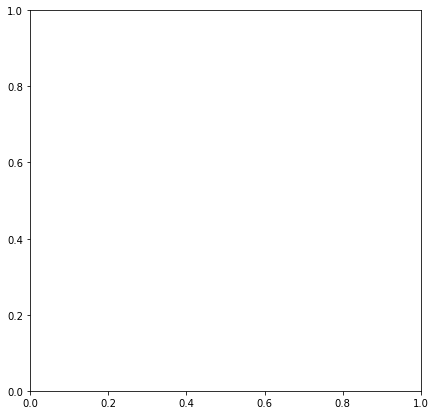

In [10]:
fig, ax = plt.subplots(figsize=(7,7))
scatter = ax.scatter(all_positions.iloc[0][0][:,0], all_positions.iloc[0][0][:,1],
                     s=50, cmap="jet", edgecolor="g", marker="D")
ax.axis([-10, 10, -10, 10])
def update(frame_number):
    scatter.set_offsets(all_positions.iloc[frame_number][0])
    return scatter

anim = animation.FuncAnimation(fig, update, frames = MAX_GENERATIONS)

In [ ]:
anim